# Train ML models

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from functions import *

In [4]:
with open('./state_and_kua.pkl', 'rb') as f:
    my_state = pickle.load(f)

In [5]:
input_vars = [
    'air_temperature', 
    'specific_humidity', 
    'eastward_wind', 
    'northward_wind', 
    'air_pressure'
]
output_vars = [
    'air_temperature_tendency_from_EmanuelConvection', 
    'specific_humidity_tendency_from_EmanuelConvection', 
    'eastward_wind_tendency_from_EmanuelConvection', 
    'northward_wind_tendency_from_EmanuelConvection',
    'convective_precipitation_rate'
]

## Load the prepared data and create train/valid split

In [13]:
stacked_inputs = xr.open_dataarray(
    'stacked_inputs_and_kua.nc', chunks={'sample': 1000})
stacked_outputs = xr.open_dataarray(
    'stacked_outputs_and_kua.nc', chunks={'sample': 1000})

In [14]:
with open('norm_arrs_and_kua.pkl', 'rb') as f:
    input_means, input_stds, output_means, output_stds = pickle.load(f)

In [15]:
ngeo = 32*64 # Samples per time step
stacked_inputs.shape

(2990080, 50)

In [16]:
split = (2_000_000 // ngeo) * ngeo; split

1998848

In [17]:
# Change of notation: X, Y are the inputs, outputs
X_train = stacked_inputs[:split].values
X_valid = stacked_inputs[split:].values
Y_train = stacked_outputs[:split].values
Y_valid = stacked_outputs[split:].values

I will not subtract the mean for the outputs, they should all be centered at zero (except precip which is just a diagnostic anyway). That way an inactive convection scheme will actually be zero.

In [18]:
X_train_norm = normalize(X_train, input_means, input_stds)
X_valid_norm = normalize(X_valid, input_means, input_stds)
Y_train_norm = normalize(Y_train, 0, output_stds)
Y_valid_norm = normalize(Y_valid, 0, output_stds)

## Train Linear Regression baseline

In [ ]:
from sklearn.linear_model import LinearRegression

In [11]:
lr = LinearRegression()

In [12]:
%%time
lr.fit(X_train_norm, Y_train_norm)

CPU times: user 36 s, sys: 17.3 s, total: 53.3 s
Wall time: 16.2 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
with open('lr_and_kua.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [14]:
lr.score(X_valid_norm, Y_valid_norm)   # R2

0.6650584882042144

In [15]:
lr_preds = lr.predict(X_valid_norm)

In [16]:
((lr_preds - Y_valid_norm)**2).mean()  # Normalized MSE

0.27855003148312535

## Train neural netwoks of different complexity

### Neural network 1

In [16]:
nn1 = keras.models.Sequential([
    Dense(128, input_shape=(50,), activation='elu'),
    Dense(128, activation='elu'),
    Dense(41)
])

In [17]:
nn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 41)                5289      
Total params: 28,329
Trainable params: 28,329
Non-trainable params: 0
_________________________________________________________________


In [18]:
nn1.compile(keras.optimizers.Adam(lr=1e-4), 'mse')

In [19]:
nn1.fit(X_train_norm, Y_train_norm, batch_size=1024, epochs=20, 
          validation_data=(X_valid_norm, Y_valid_norm))

Train on 1998848 samples, validate on 991232 samples
Epoch 1/20
1998848/1998848 [==============================] - 23s 12us/sample - loss: 0.3375 - val_loss: 0.2007
Epoch 2/20
1998848/1998848 [==============================] - 24s 12us/sample - loss: 0.1736 - val_loss: 0.1635
Epoch 3/20
1998848/1998848 [==============================] - 18s 9us/sample - loss: 0.1483 - val_loss: 0.1444
Epoch 4/20
1998848/1998848 [==============================] - 23s 11us/sample - loss: 0.1354 - val_loss: 0.1349
Epoch 5/20
1998848/1998848 [==============================] - 23s 12us/sample - loss: 0.1278 - val_loss: 0.1288
Epoch 6/20
1998848/1998848 [==============================] - 21s 10us/sample - loss: 0.1227 - val_loss: 0.1245
Epoch 7/20
1998848/1998848 [==============================] - 22s 11us/sample - loss: 0.1189 - val_loss: 0.1201
Epoch 8/20
1998848/1998848 [==============================] - 26s 13us/sample - loss: 0.1157 - val_loss: 0.1174
Epoch 9/20
1998848/1998848 [========================

In [20]:
nn1.save('./nn1.h5')

### A better neural network 2

In [26]:
nn2 = keras.models.Sequential([
    Dense(256, input_shape=(50,), activation='elu'),
    Dense(256, activation='elu'),
    Dense(256, activation='elu'),
    Dense(256, activation='elu'),
    Dense(256, activation='elu'),
    Dense(41)
])

In [27]:
nn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               13056     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 41)                10537     
Total params: 286,761
Trainable params: 286,761
Non-trainable params: 0
_________________________________________________________________


In [28]:
nn2.compile(keras.optimizers.Adam(lr=1e-4), 'mse')

In [56]:
X_train_norm.shape, Y_train_norm.shape

((1998848, 50), (1998848, 41))

In [29]:
nn2.fit(X_train_norm, Y_train_norm, batch_size=1024, epochs=50, 
          validation_data=(X_valid_norm, Y_valid_norm))

Train on 1998848 samples, validate on 991232 samples
Epoch 1/50
1998848/1998848 [==============================] - 73s 36us/sample - loss: 0.1812 - val_loss: 0.1281
Epoch 2/50
1998848/1998848 [==============================] - 73s 36us/sample - loss: 0.1114 - val_loss: 0.1073
Epoch 3/50
1998848/1998848 [==============================] - 72s 36us/sample - loss: 0.0997 - val_loss: 0.0995
Epoch 4/50
1998848/1998848 [==============================] - 72s 36us/sample - loss: 0.0925 - val_loss: 0.0917
Epoch 5/50
1998848/1998848 [==============================] - 72s 36us/sample - loss: 0.0872 - val_loss: 0.0882
Epoch 6/50
1998848/1998848 [==============================] - 72s 36us/sample - loss: 0.0833 - val_loss: 0.0845
Epoch 7/50
1998848/1998848 [==============================] - 72s 36us/sample - loss: 0.0798 - val_loss: 0.0811
Epoch 8/50
1998848/1998848 [==============================] - 71s 36us/sample - loss: 0.0772 - val_loss: 0.0775
Epoch 9/50
1998848/1998848 [=======================

In [30]:
nn2.save('./nn2.h5')

### An intermediate neural network 3

In [10]:
nn3 = keras.models.Sequential([
    Dense(256, input_shape=(50,), activation='elu'),
    Dense(256, activation='elu'),
    Dense(41)
])

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
nn3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               13056     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 41)                10537     
Total params: 89,385
Trainable params: 89,385
Non-trainable params: 0
_________________________________________________________________


In [12]:
nn3.compile(keras.optimizers.Adam(lr=1e-4), 'mse')

Instructions for updating:
Use tf.cast instead.


In [13]:
nn3.fit(X_train_norm, Y_train_norm, batch_size=1024, epochs=50, 
          validation_data=(X_valid_norm, Y_valid_norm))

Train on 1998848 samples, validate on 991232 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1998848/1998848 [==============================] - 31s 16us/sample - loss: 0.2793 - val_loss: 0.1757
Epoch 2/50
1998848/1998848 [==============================] - 30s 15us/sample - loss: 0.1550 - val_loss: 0.1448
Epoch 3/50
1998848/1998848 [==============================] - 31s 16us/sample - loss: 0.1351 - val_loss: 0.1320
Epoch 4/50
1998848/1998848 [==============================] - 31s 15us/sample - loss: 0.1252 - val_loss: 0.1246
Epoch 5/50
1998848/1998848 [==============================] - 32s 16us/sample - loss: 0.1190 - val_loss: 0.1188
Epoch 6/50
1998848/1998848 [==============================] - 34s 17us/sample - loss: 0.1146 - val_loss: 0.1152
Epoch 7/50
1998848/1998848 [==============================] - 32s 16us/sample - loss: 0.1111 - val_loss: 0.1118
Epoch 8/50
1998848/1998848 [==============================] - 33s 16us/sample - loss: 0.1082 - val_loss: 0.1092
Epo

In [14]:
nn3.save('./nn3.h5')

## Train a Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

In [61]:
rf = RandomForestRegressor(
    n_estimators=10,
    min_samples_leaf=100,
    n_jobs=10,
    verbose=100
)

In [62]:
%%time
rf.fit(X_train_norm, Y_train_norm)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
building tree 1 of 10building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed: 18.9min
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed: 19.1min remaining: 76.2min
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 19.3min remaining: 45.1min
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed: 19.3min remaining: 29.0min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 19.6min remaining: 19.6min
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed: 19.8min remaining: 13.2min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 20.1min remaining:  8.6min
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed: 20.1min remaining:  5.0min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 20.3min remain

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=100, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=10,
                      oob_score=False, random_state=None, verbose=100,
                      warm_start=False)

In [63]:
with open('rf2.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [72]:
rf.score(X_valid_norm, Y_valid_norm)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    8.0s remaining:   31.9s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    8.2s remaining:   19.1s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    9.2s remaining:    6.1s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    9.5s remaining:    4.1s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:   10.0s remaining:    2.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   10.9s finished


0.8780910687614585

## Offline evaluation

In [19]:
with open('rf1.pkl', 'rb') as f:
    rf = pickle.load(f)

In [20]:
with open('lr_and_kua.pkl', 'rb') as f:
    lr = pickle.load(f)

In [28]:
nn2 = keras.models.load_model('./nn2.h5')
nn1 = keras.models.load_model('./nn1.h5')
nn3 = keras.models.load_model('./nn3.h5')

In [22]:
def split_predictions(Y):
    outputs = {}
    ntime = Y.shape[0] // ngeo
    dims = ['time', 'lat', 'lon', 'mid_levels']
    for i, o in enumerate(output_vars):
        outputs[o] = xr.DataArray(
            Y[:, i*10:(i+1)*10].reshape((ntime, 32, 64, -1)),
            dims=dims
        ).squeeze()
    return xr.Dataset(outputs).transpose('time', 'mid_levels', 'lat', 'lon')

In [74]:
nn1_preds = nn1.predict(X_valid_norm, 10_000)
nn2_preds = nn2.predict(X_valid_norm, 10_000)
nn3_preds = nn3.predict(X_valid_norm, 10_000)
nn2_preds.shape

(991232, 41)

In [83]:
# Overall R2
tvar = np.var(Y_valid_norm)
mse = np.mean((nn2_preds - Y_valid_norm)**2)
1-mse/tvar

0.9450004237373084

In [84]:
# Overall R2
mse = np.mean((nn1_preds - Y_valid_norm)**2)
1-mse/tvar

0.906490394308376

In [77]:
rf_preds = rf.predict(X_valid_norm)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    6.0s remaining:   23.8s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    6.4s remaining:   14.9s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:    7.3s remaining:    7.3s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:    7.6s remaining:    5.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    7.8s remaining:    3.3s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:    8.2s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    9.0s finished


In [85]:
# Overall R2
mse = np.mean((rf_preds - Y_valid_norm)**2)
1-mse/tvar

0.9045581909375073

In [86]:
lr_preds = lr.predict(X_valid_norm)

In [87]:
# Overall R2
mse = np.mean((lr_preds - Y_valid_norm)**2)
1-mse/tvar

0.737776194974793

In [30]:
nn1_preds = split_predictions(unnormalize(nn1_preds, 0, output_stds))
nn2_preds = split_predictions(unnormalize(nn2_preds, 0, output_stds))
nn3_preds = split_predictions(unnormalize(nn3_preds, 0, output_stds))

In [64]:
rf_preds = split_predictions(unnormalize(rf.predict(X_valid_norm), 0, output_stds))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   11.6s remaining:   46.4s
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   11.8s remaining:   27.6s
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:   12.0s remaining:   18.0s
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:   12.2s remaining:   12.2s
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:   12.4s remaining:    8.3s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:   12.8s remaining:    5.5s
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:   13.3s remaining:    3.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   14.0s finished


In [32]:
lr_preds = split_predictions(unnormalize(lr.predict(X_valid_norm), 0, output_stds))

In [33]:
truth = split_predictions(Y_valid)

In [34]:
nn1_error = nn1_preds - truth
nn2_error = nn2_preds - truth
nn3_error = nn3_preds - truth

In [65]:
rf_error = rf_preds - truth

In [36]:
lr_error = lr_preds - truth

### Plots

In [29]:
def plot_comparison(var, sl=None, mean=None, std=None):
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))
    for ds, n, ax in zip(
        [nn_preds, rf_preds, lr_preds, truth, nn_error, rf_error, lr_error], 
        ['nn_preds', 'rf_preds', 'lr_preds', 'truth', 'nn_error', 'rf_error', 'lr_error'],
        axs.flat):
        if mean is not None: ds = ds.mean(mean)
        if std is not None: ds = ds.std(std)
        ds[var].isel(sl).plot(ax=ax); ax.set_title(n)
    plt.tight_layout()

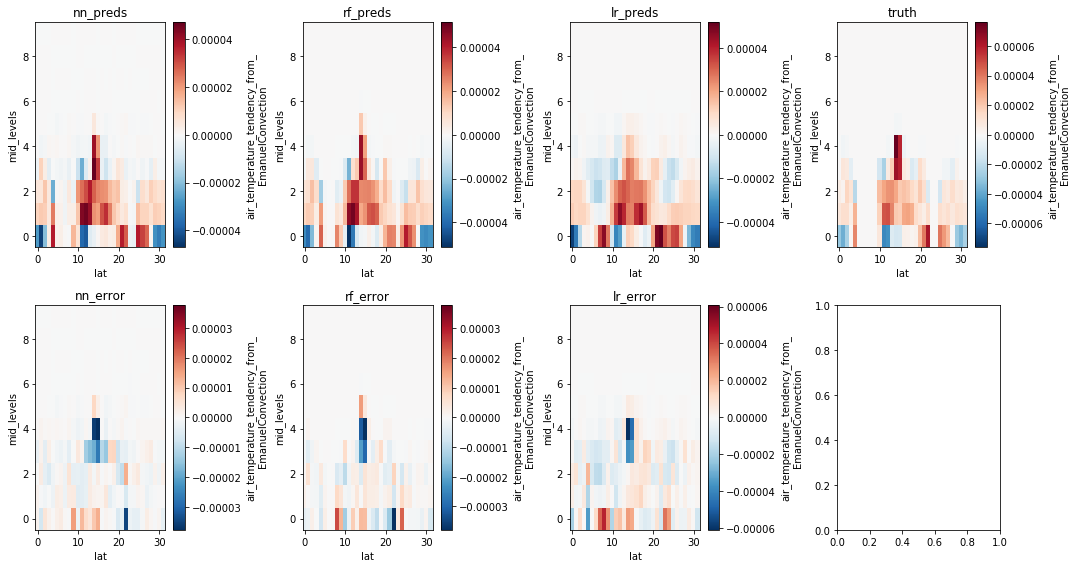

In [58]:
plot_comparison(
    'air_temperature_tendency_from_EmanuelConvection',
    {'time': -1, 'lon': 0}
)

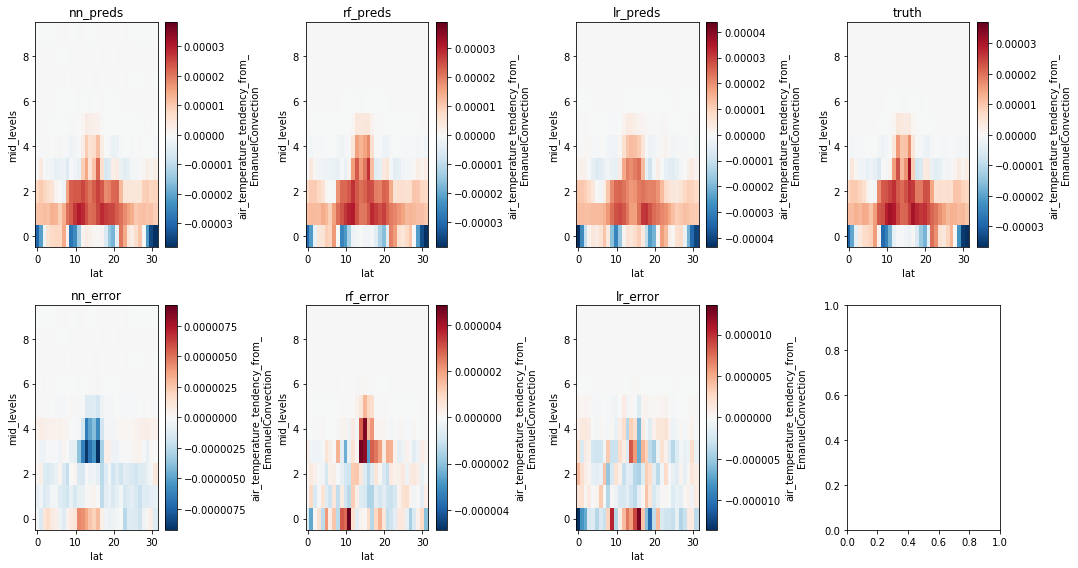

In [59]:
plot_comparison(
    'air_temperature_tendency_from_EmanuelConvection',
    mean=('time', 'lon')
)

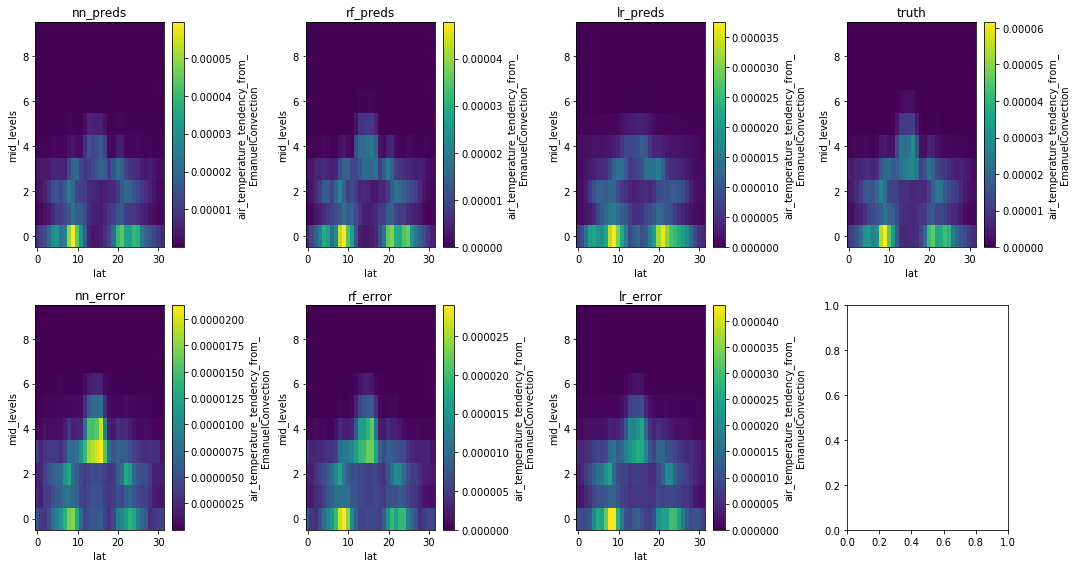

In [60]:
plot_comparison(
    'air_temperature_tendency_from_EmanuelConvection',
    std=('time', 'lon')
)

### Compute R2



In [66]:
tvar = ((truth - truth.mean(('time', 'lon')))**2).mean(('time', 'lon'))
nn1_sse = (nn1_error**2).mean(('time', 'lon'))
nn1_r2 = 1-(nn1_sse/tvar)
nn2_sse = (nn2_error**2).mean(('time', 'lon'))
nn2_r2 = 1-(nn2_sse/tvar)
nn3_sse = (nn3_error**2).mean(('time', 'lon'))
nn3_r2 = 1-(nn3_sse/tvar)
rf_sse = (rf_error**2).mean(('time', 'lon'))
rf_r2 = 1-(rf_sse/tvar)
lr_sse = (lr_error**2).mean(('time', 'lon'))
lr_r2 = 1-(lr_sse/tvar)

#### Overall R2

In [67]:
mask = ((tvar['air_temperature_tendency_from_EmanuelConvection']/
         tvar['air_temperature_tendency_from_EmanuelConvection'].mean()) > 0.01)

In [68]:
# def plot_r2(var, **kwargs):
#     fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 4.5))
#     (lr_r2[var]*mask).plot(ax=ax1, **kwargs)
#     ax1.set_title('Linear regression')
    
#     (nn1_r2[var]*mask).plot(ax=ax2, **kwargs)
#     ax2.set_title('Small neural network')
    
#     (nn3_r2[var]*mask).plot(ax=ax3, **kwargs)
#     ax3.set_title('Intermediate neural network')
    
#     (nn2_r2[var]*mask).plot(ax=ax4, **kwargs)
#     ax4.set_title('Big neural network')
    
#     (rf_r2[var]*mask).plot(ax=ax5, **kwargs)
#     ax5.set_title('Random forest')
    
#     plt.tight_layout() 
    
def plot_r2(var, **kwargs):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4.3))
    (lr_r2[var]*mask).plot(ax=ax1, **kwargs)
    ax1.set_title('Linear regression')
    
    (nn1_r2[var]*mask).plot(ax=ax2, **kwargs)
    ax2.set_title('Small neural network')
    
    (nn2_r2[var]*mask).plot(ax=ax3, **kwargs)
    ax3.set_title('Big neural network')
    
    (rf_r2[var]*mask).plot(ax=ax4, **kwargs)
    ax4.set_title('Random forest')
    
    plt.tight_layout() 

In [69]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

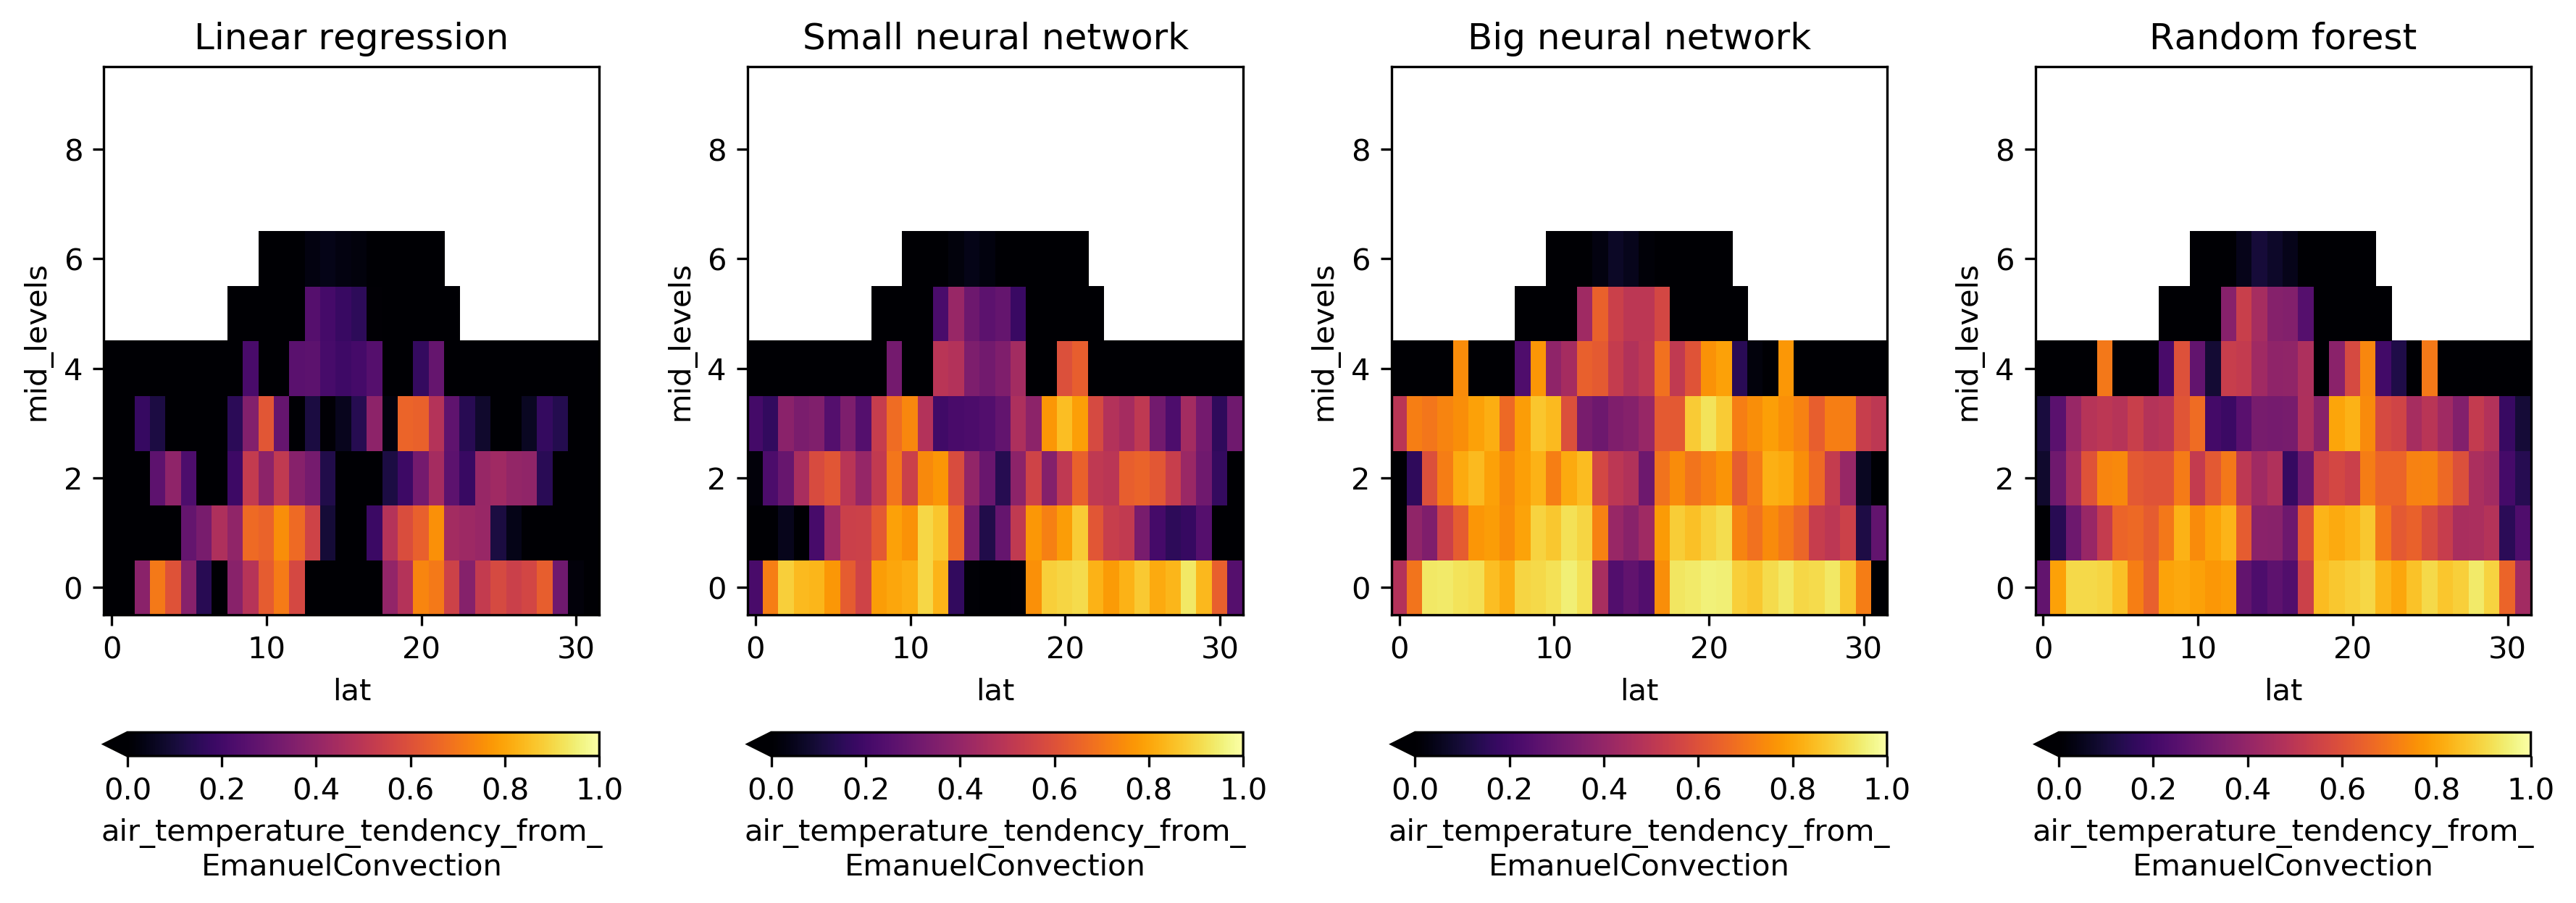

In [70]:
plot_r2('air_temperature_tendency_from_EmanuelConvection', vmin=0, vmax=1, 
        cbar_kwargs={'orientation': 'horizontal'}, cmap='inferno')

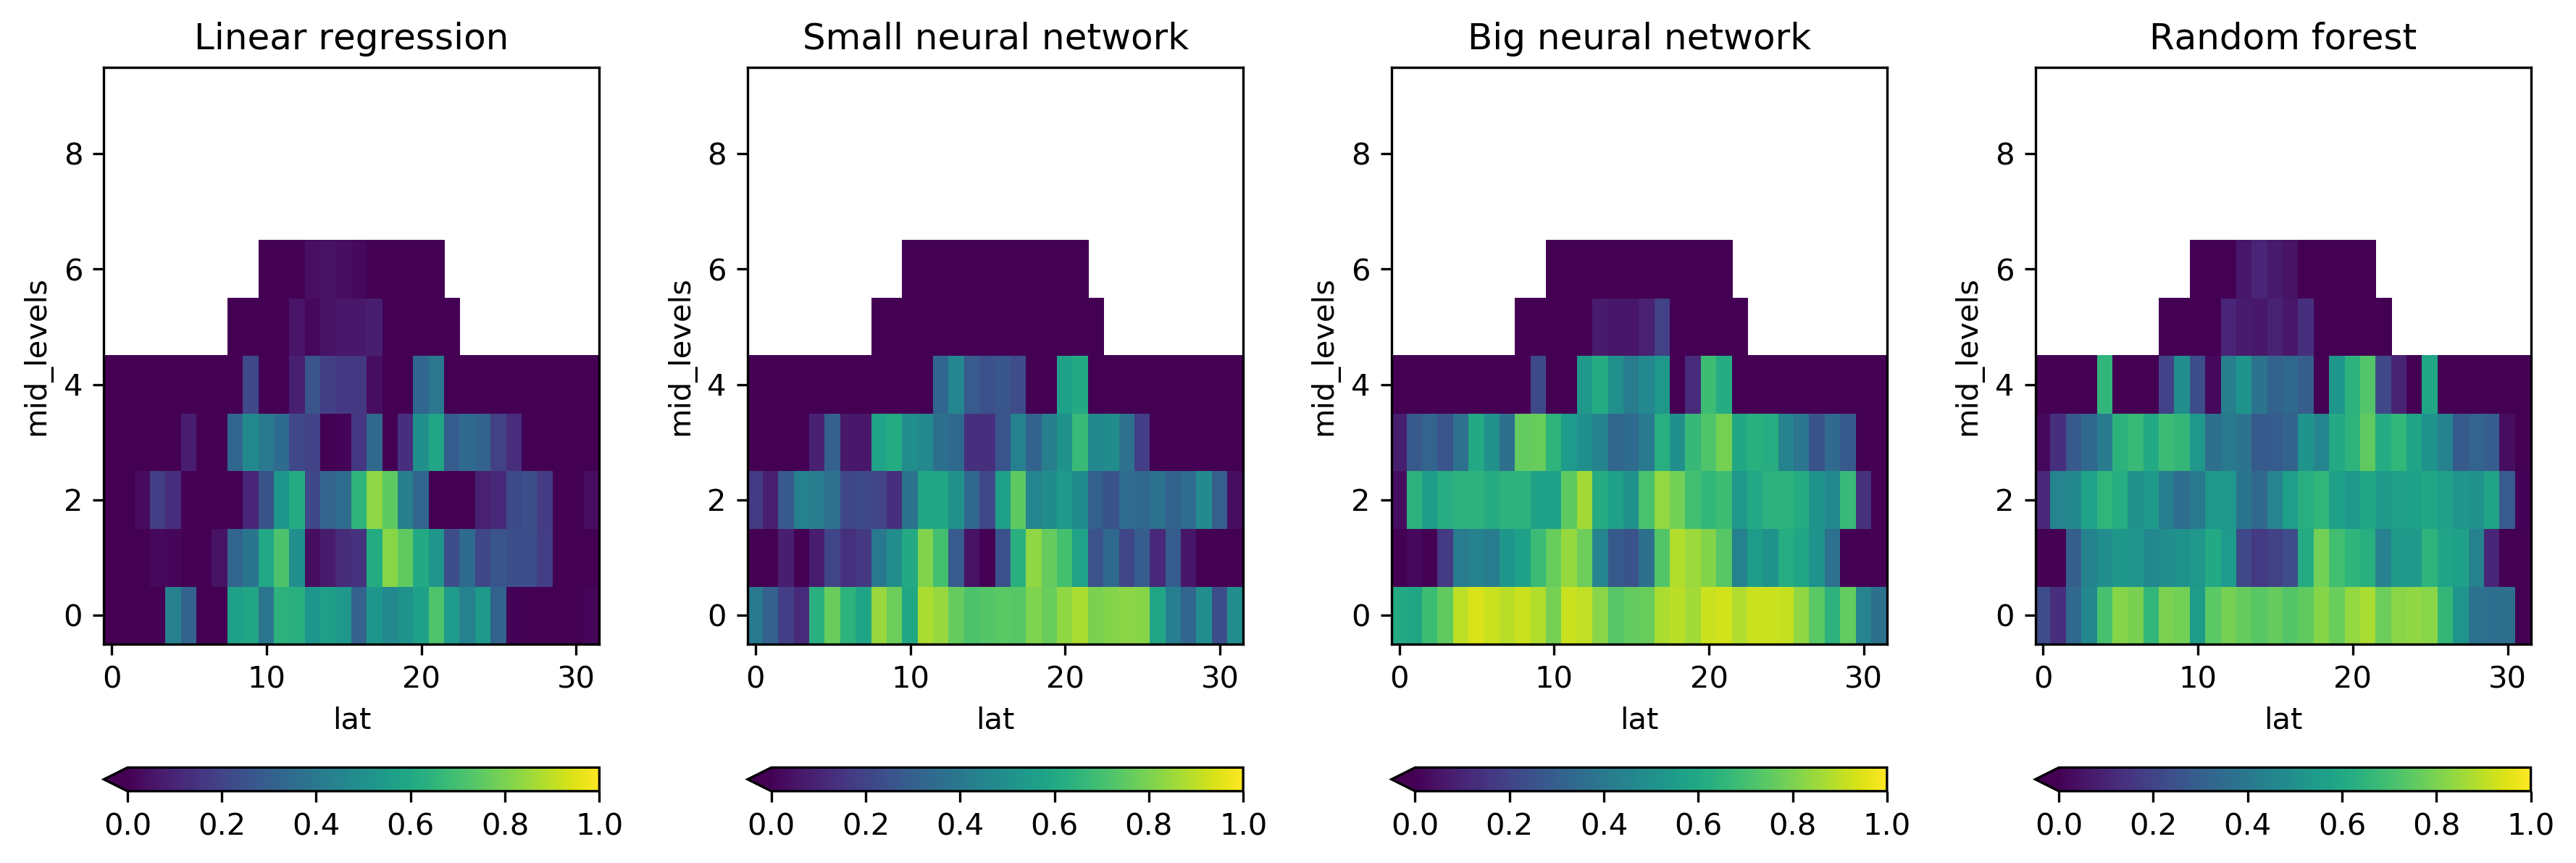

In [71]:
plot_r2('specific_humidity_tendency_from_EmanuelConvection', vmin=0, vmax=1, 
        cbar_kwargs={'orientation': 'horizontal'})

(-1, 1)

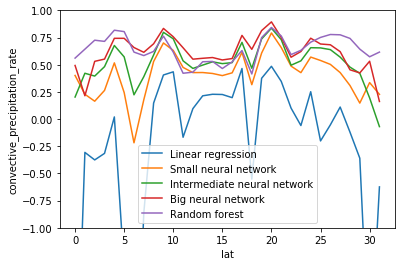

In [36]:
lr_r2['convective_precipitation_rate'].plot(label='Linear regression')
nn1_r2['convective_precipitation_rate'].plot(label='Small neural network')
nn3_r2['convective_precipitation_rate'].plot(label='Intermediate neural network')
nn2_r2['convective_precipitation_rate'].plot(label='Big neural network')
rf_r2['convective_precipitation_rate'].plot(label='Random forest')
plt.legend();  plt.ylim(-1, 1)